# Red Neuronal para discriminacion de Gamma/Neutron

Se creara una red neuronal que discrimine entre Gamma y Neutrones a partir de sus trazas de evento, esto a traves de Machine Learning implementado en la FPGA

---

## Entrenamiento
Este entrenamiento se realizará basado en el trabajo previo:
- Workflow based on R. S. Molina, I. R. Morales, M. L. Crespo, V. G. Costa, S. Carrato and G. Ramponi, "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA", in IEEE Embedded Systems Letters, vol. 16, no. 3, pp. 255-258, Sept. 2024, doi: 10.1109/LES.2023.3343030.
- Code adapted from the official repository of "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA"
- Using open dataset from: https://doi.org/10.5281/zenodo.8037058


### Importación de librerias

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

# Tensorflow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

# Pruning API
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_schedule, pruning_callbacks
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# Quantization API
from qkeras import *

# Knowledge Distillation
from src.distillationClassKeras import *

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Training utils
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)


Evaluamos el numero de GPUs disponibles para entrenamiento

In [2]:
# import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(physical_devices))
print("Available devices: ", physical_devices)

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  0
Available devices:  []


In [3]:
# Function to define the training and testing datasets

def preproc_dataset_(signal_dfN, signal_dfG):
    # data for Neutrons and Gammas
    # Label in csv file corresponds to the signal class (0: gamma, 1: neutron)
    _LABEL_COLUMN = 'class' 

    dfTest  = pd.DataFrame()
    dfTrain = pd.DataFrame()

    signal_dfN = shuffle(signal_dfN)
    signal_dfG = shuffle(signal_dfG)

    signal_df = pd.concat([signal_dfN, signal_dfG])

    for k in range(0,2):
        df2 = signal_df[signal_df[_LABEL_COLUMN].isin([k])]

        df_tr = df2[:10000]
        df_t  = df2[10001:10900]

        dfTrain = pd.concat([df_tr, dfTrain])
        dfTest  = pd.concat([df_t, dfTest])

    return dfTrain, dfTest


In [4]:
# Define paths to datasets

PATH = 'dataset/'

GAMMA_DATASET_FILE   = PATH + 'gamma_label.csv'
NEUTRON_DATASET_FILE = PATH + 'neutron_label.csv'

TEST_DATASET_FILE  = PATH + 'test.csv'

# Load datasets
dfGamma   = pd.read_csv(GAMMA_DATASET_FILE)
dfNeutron = pd.read_csv(NEUTRON_DATASET_FILE)
dfTestGN  = pd.read_csv(TEST_DATASET_FILE)

### Preprocesamiento y separacion de dataset

Separacion del dataset en datos de entrenamiento y de test

In [5]:
# Pre-processing dataset for training
df_train, dfTest = preproc_dataset_(dfNeutron, dfGamma)

# Save the test
# dfTest.to_csv('dataset/test.csv')

df_train_ = df_train.pop('class')
dfTest_   = dfTest.pop('class')

# One-hot encoder
le = LabelEncoder()
y = le.fit_transform(df_train_)
y = to_categorical(df_train_, 2)

le = LabelEncoder()
yTest = le.fit_transform(dfTest_)
yTest = to_categorical(dfTest_, 2)

# Split training dataset into training and validation
x_train, x_val, y_train, y_val = train_test_split(df_train, y, test_size=0.3, random_state=42)


## Carga del modelo

Aqui se carga el modelo y los datos de entrenamiento

In [6]:
teacher_model = keras.models.load_model("models/teacherModel_GN_GICM.h5")
teacher_model.summary()

Model: "teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 10)                1620      
                                                                 
 relu1 (Activation)          (None, 10)                0         
                                                                 
 fc2 (Dense)                 (None, 5)                 55        
                                                                 
 relu2 (Activation)          (None, 5)                 0         
                                                                 
 fc3 (Dense)                 (None, 7)                 42        
                                                                 
 relu3 (Activation)          (None, 7)                 0         
                                                                 
 dropout (Dropout)           (None, 7)                 

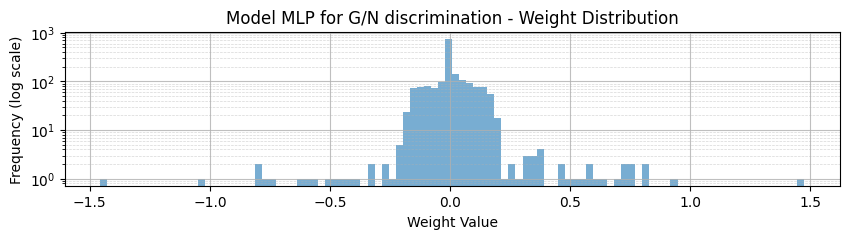

In [7]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in teacher_model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution")

# Escala logarítmica en el eje Y
plt.yscale("log")

# Grid principal -> línea continua
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)

# Grid secundario -> línea punteada y tenue
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)

plt.show()

57/57 [==============================] - 0s 673us/step


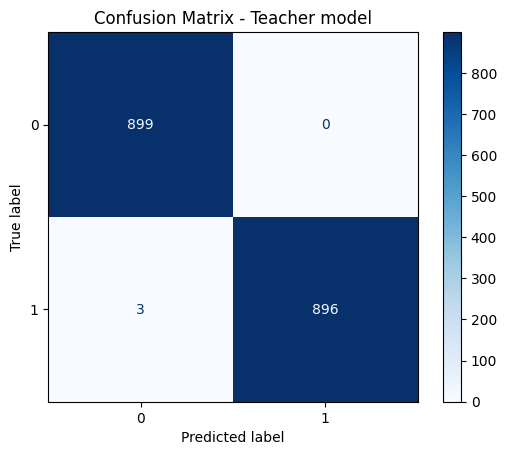

In [8]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = teacher_model.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
#plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix - Teacher model')
plt.show()

### Podado, Pruning

Aqui se hara el proceso de podado y reduccion de complejidad del modelo para el modelo entrenado. Primero se cargara el modelo previamente guardado

In [9]:
epochs = 32
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2

final_sparsity = 0.3 # percentage of weights pruned

pruning_params = {
                 'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                    initial_sparsity=0, 
                    final_sparsity=final_sparsity, 
                    begin_step=0, 
                    end_step=1000
                 )
                 }

In [10]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience=2,
    #     verbose=1,
    #     restore_best_weights=True
    # ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', #'val_loss',
        factor=0.4,
        patience=3,
        verbose=1
    ), 
    pruning_callbacks.UpdatePruningStep()
]

### Podado del modelo

In [11]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)
modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [12]:
history_P = modelP.fit(x=x_train, y=y_train,
                       validation_split=val_split,
                       batch_size=64, 
                       epochs=32,
                       callbacks= [callbacks],
                       verbose=1
                       )

Epoch 1/32
175/175 [==============================] - 3s 3ms/step - loss: 0.5139 - accuracy: 0.9380 - val_loss: 0.0679 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 2/32
175/175 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.9779 - val_loss: 0.0690 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 3/32
175/175 [==============================] - 0s 1ms/step - loss: 0.1046 - accuracy: 0.9807 - val_loss: 0.0629 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 4/32
175/175 [==============================] - 0s 2ms/step - loss: 0.1022 - accuracy: 0.9805 - val_loss: 0.0609 - val_accuracy: 0.9946 - lr: 0.0010
Epoch 5/32
175/175 [==============================] - 0s 1ms/step - loss: 0.1057 - accuracy: 0.9797 - val_loss: 0.0637 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 6/32
175/175 [==============================] - 0s 2ms/step - loss: 0.0941 - accuracy: 0.9836 - val_loss: 0.0674 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 7/32
175/175 [==============================] - 0s 2ms/step - lo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


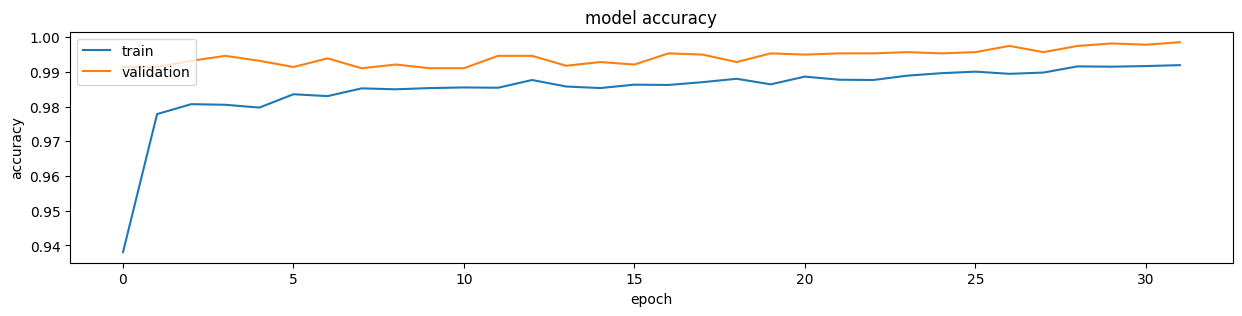

<Figure size 640x480 with 0 Axes>

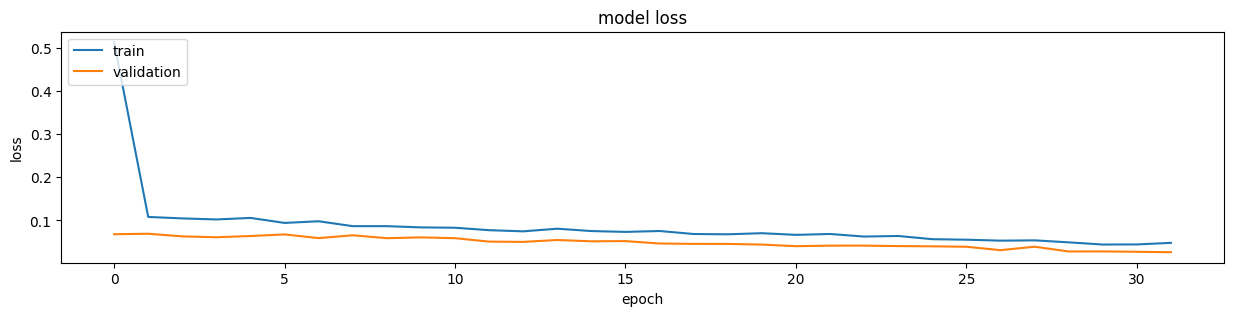

In [13]:
print(history_P.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_P.history['accuracy'])
plt.plot(history_P.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_P.history['loss'])
plt.plot(history_P.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

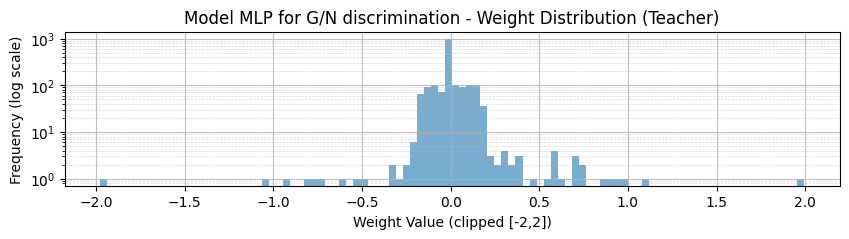

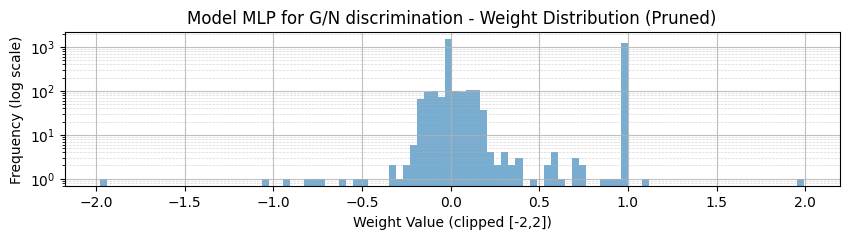

In [14]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in teacher_model.get_weights()])
weights_p = np.concatenate([w.flatten() for w in modelP.get_weights()])

# Filtrar pesos entre -2 y 2
weights_clip  = weights[(weights >= -2) & (weights <= 2)]
weights_p_clip = weights_p[(weights_p >= -2) & (weights_p <= 2)]

# Histograma del modelo original
plt.figure(figsize=(10,2))
plt.hist(weights_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Teacher)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

# Histograma del modelo podado
plt.figure(figsize=(10,2))
plt.hist(weights_p_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Pruned)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()


### Confusion matrix

Matriz de confusion despues del podado

57/57 [==============================] - 0s 828us/step


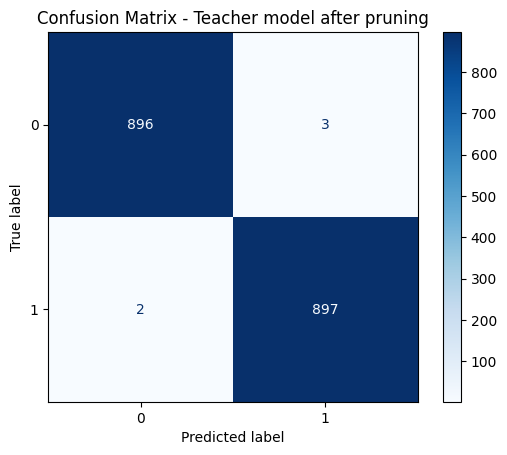

In [15]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = modelP.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix - Teacher model after pruning')
plt.show()

---

## Cuantizacion (QAT)

Aqui se aplicara la cuantizacion para reducir el tamaño y resolucion de la red

In [16]:
## Estrategia de cuantizacion

## Definicion del numero de bits para kernel, bias, y activacion.
# 8-bits

neurons_teacher = [10, 5, 7, 5, 6]

kernelQ      = "quantized_bits(8,4,alpha=1)"
biasQ        = "quantized_bits(8,4,alpha=1)"
activationQ  = "quantized_bits(8,4,alpha=1)"

modelQAT = Sequential(
    [
        QDense(neurons_teacher[0], name='input', input_shape=(161,),
                           kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                           kernel_initializer='lecun_uniform'),
                    QActivation(activation=activationQ, name='relu0'),
                    # Dropout(0.1),

                    QDense(neurons_teacher[1], name='fc1', 
                           kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                           kernel_initializer='lecun_uniform'),
                    QActivation(activation=activationQ, name='relu1'),
                    # Dropout(0.1),

                    QDense(neurons_teacher[2], name='fc2',
                           kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                           kernel_initializer='lecun_uniform'),
                    QActivation(activation=activationQ, name='relu2'),
                    Dropout(0.1),

                    QDense(neurons_teacher[3], name='fc3',
                           kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                           kernel_initializer='lecun_uniform'),
                    QActivation(activation=activationQ, name='relu3'), 
                    Dropout(0.2),
                
                    QDense(neurons_teacher[4], name='fc4',
                           kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                           kernel_initializer='lecun_uniform'),
                    QActivation(activation=activationQ, name='relu4'), 
                    Dropout(0.2),
                
                    QDense(2, name='output',
                           kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                           kernel_initializer='lecun_uniform'),
                    Activation(activation='sigmoid', name='sigmoid')       
    ], 
    name = "QuantizedModel",
)


In [17]:
modelQAT.summary()

Model: "QuantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (QDense)              (None, 10)                1620      
                                                                 
 relu0 (QActivation)         (None, 10)                0         
                                                                 
 fc1 (QDense)                (None, 5)                 55        
                                                                 
 relu1 (QActivation)         (None, 5)                 0         
                                                                 
 fc2 (QDense)                (None, 7)                 42        
                                                                 
 relu2 (QActivation)         (None, 7)                 0         
                                                                 
 dropout (Dropout)           (None, 7)              

### Creacion del modelo cuantizado

Aqui se realiza el entrenamiento

In [18]:
ephocs = 32
lr = 0.0001
loss = 'binary_crossentropy'
op = Adam(learning_rate=lr)
metrics = ['accuracy']
batch = 32  
val_split = 0.2

modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)

history_QAT = modelQAT.fit(x=x_train, y=y_train,
                       validation_split=val_split,
                       epochs=epochs,
                       batch_size=batch,
                       verbose=1
                       )


Epoch 1/32
350/350 [==============================] - 2s 2ms/step - loss: 1.8839 - accuracy: 0.7558 - val_loss: 0.3218 - val_accuracy: 0.9496
Epoch 2/32
350/350 [==============================] - 1s 1ms/step - loss: 0.6079 - accuracy: 0.9235 - val_loss: 0.1212 - val_accuracy: 0.9918
Epoch 3/32
350/350 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.9409 - val_loss: 0.1500 - val_accuracy: 0.9771
Epoch 4/32
350/350 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.9553 - val_loss: 0.0515 - val_accuracy: 0.9875
Epoch 5/32
350/350 [==============================] - 0s 1ms/step - loss: 0.3616 - accuracy: 0.9556 - val_loss: 0.2492 - val_accuracy: 0.9789
Epoch 6/32
350/350 [==============================] - 0s 1ms/step - loss: 0.3351 - accuracy: 0.9629 - val_loss: 0.1730 - val_accuracy: 0.9814
Epoch 7/32
350/350 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.9659 - val_loss: 0.0677 - val_accuracy: 0.9907
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


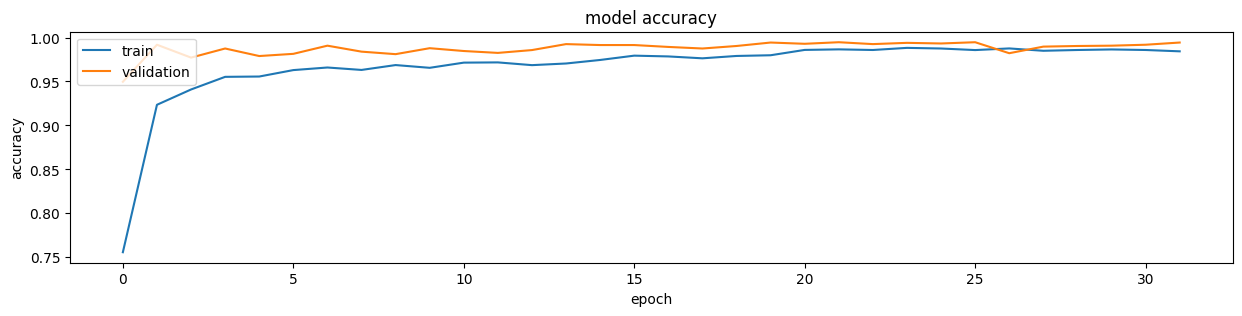

<Figure size 640x480 with 0 Axes>

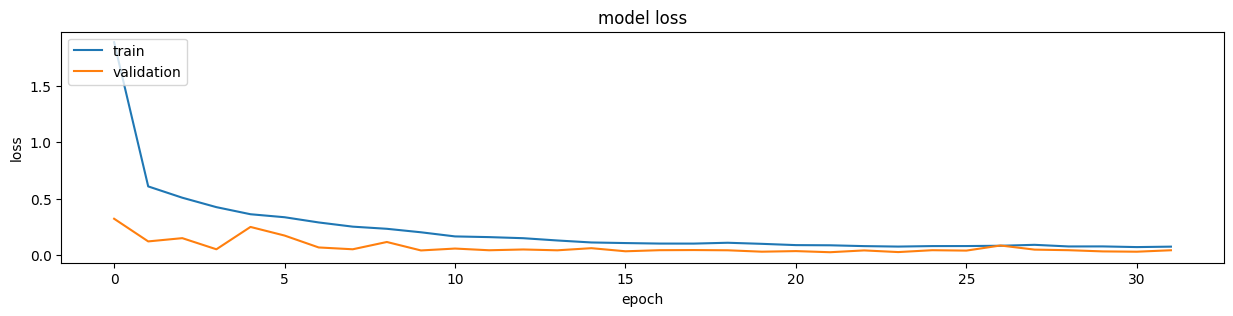

In [19]:
print(history_QAT.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_QAT.history['accuracy'])
plt.plot(history_QAT.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_QAT.history['loss'])
plt.plot(history_QAT.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

57/57 [==============================] - 0s 920us/step


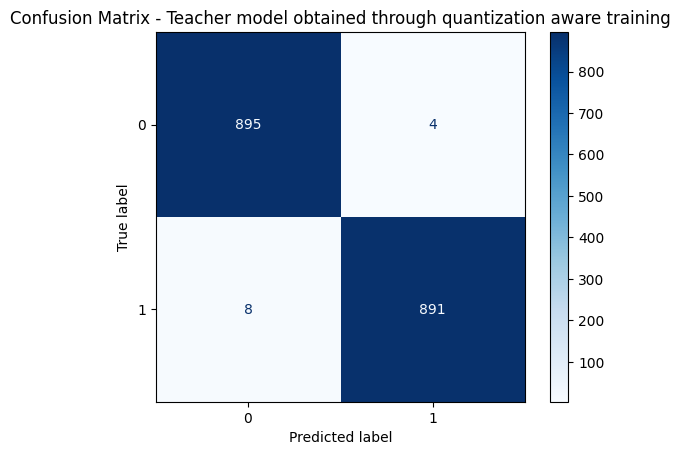

In [20]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = modelQAT.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix - Teacher model obtained through quantization aware training')
plt.show()

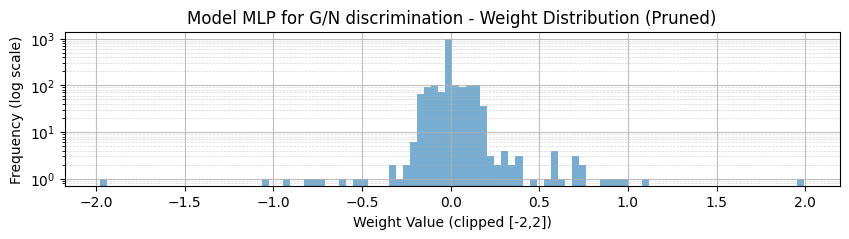

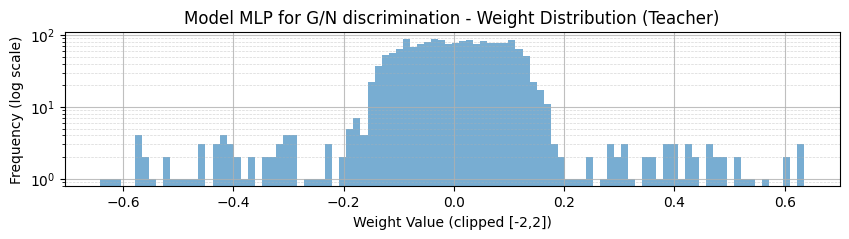

In [23]:
# Weight distribution

weights_qat = np.concatenate([w.flatten() for w in modelQAT.get_weights()])

# Filtrar pesos entre -2 y 2
weights_qat_clip  = weights_qat[(weights_qat >= -2) & (weights_qat <= 2)]

# Histograma del modelo podado
plt.figure(figsize=(10,2))
plt.hist(weights_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Pruned)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

# Histograma del modelo original
plt.figure(figsize=(10,2))
plt.hist(weights_qat_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Teacher)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

In [ ]:
# If needed, save the teacher QAT model [uncomment the following line]
# modelQAT.save('models/teacherQATModel_GN_GICM.h5')

---

# Entrenamiento del modelo Student

Para obtener el modelo reducido que será implementado en la FPGA (llamado en adelante red estudiante), se empleará un enfoque de aprendizaje por destilación de conocimiento (**KD**).

En este método, el modelo maestro transfiere lo aprendido al modelo estudiante.

El modelo estudiante se define aplicando cuantización y poda.

En este proyecto se fijaron:

- 8 bits para la cuantización
- 50% de sparsity (poda de la mitad de los pesos).

Para la cuantización se utiliza QKeras, una librería especializada para redes neuronales cuantizadas y optimizadas para hardware.

**Referencia sobre QKeras**:
Coelho et al. (2020). Ultra low-latency, low-area inference accelerators using heterogeneous deep quantization with QKeras and hls4ml. arXiv:2006.10159.

### Hiperparametros para el modelo Student

In [26]:
# Define the hyperparameters for the student model
lr = 0.001
neurons_student = [6, 4, 2, 4, 3]

In [27]:
def student_topology(neurons_student):
    
    '''
    Model to be trained. Defined with quantization strategies. 
    Input: hyperparams. (bestHP)
    Output: compressed model (studentQ_MLP). 

    '''
    ######## ---------------------------  Model definition - 1D STUDENT -----------------------------------------

    # Number of bits 
    ## 4-bits
    kernelQ_4b = "quantized_bits(4,2,alpha=1)"
    biasQ_4b = "quantized_bits(4,2,alpha=1)"
    activationQ_4b = 'quantized_bits(4, 0)'

    ## 8-bits
    kernelQ = "quantized_bits(8,4,alpha=1)"
    biasQ = "quantized_bits(8,4,alpha=1)"
    activationQ = 'quantized_bits(8)'
    
    ## 16-bits
    kernelQ_16b = "quantized_bits(16,6,alpha=1)"
    biasQ_16b = "quantized_bits(16,6,alpha=1)"
    activationQ_16b = 'quantized_bits(16)'
    
    studentQ_MLP = keras.Sequential(
            [   
                Input(shape=(161,), name='inputLayer'),
                QDense(neurons_student[0], name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu0'),
                Dropout(0.1),
                    
                QDense(neurons_student[1], name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu1'), 
                Dropout(0.1),
                

                QDense(neurons_student[2], name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),

                QDense(neurons_student[3], name='fc4',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                Dropout(0.2),

                QDense(neurons_student[4], name='fc5',
                       kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                       kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu4'), 
                Dropout(0.2),
               
                QDense(2, name='output',
                        kernel_quantizer= kernelQ_16b, bias_quantizer= biasQ_16b,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='sigmoid', name='outputActivation')

                
            ],
            name="studentMLP",
        )


    return studentQ_MLP

### Construccion del modelo


In [28]:
# Build student model with pruning strategy

def build_student(student_neurons):

    '''
    Model to be compressed. Defined with quantization strategies. 
    Input: hyperparams (student_neurons).
    Output: compressed model (studentQ). 

    '''
    
    qmodel = student_topology(student_neurons)

    # Pruning parameters 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
    }
    
    studentQ = prune.prune_low_magnitude(qmodel, **pruning_params)
    
    
    return studentQ

---

### Compilacion del modelo Student para KD y QAT

Compilacion para destilacion de conocimiento y cuantizacion

In [36]:
studentQ = build_student(neurons_student)
studentQ.summary()

Model: "studentMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 6)                1940      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_relu0 (  (None, 6)                1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dropout  (None, 6)                1         
 _8 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_fc2 (Pr  (None, 4)                54        
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_relu1 (  (None, 4)                1

In [37]:
distilled_student = Distiller(student=studentQ, teacher=modelQAT)
adam = Adam(learning_rate=lr)
train_labels = np.argmax(y_train, axis=1)

distilled_student.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1,
        temperature=10,
    )

### Entrenamiento del modelo Student

In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_student_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_student_loss', #'val_loss',
        factor=0.3,
        patience=3,
        verbose=1
    ), 
    pruning_callbacks.UpdatePruningStep(),
]

history_student = distilled_student.fit(
    x=x_train,
    y=train_labels,
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
)

Epoch 1/50


c:\GitHub\FPGA_ml4hls_prj\PythonModel\env\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


175/175 [==============================] - 5s 4ms/step - sparse_categorical_accuracy: 0.8135 - student_loss: 0.4288 - distillation_loss: 7.6718e-04 - val_sparse_categorical_accuracy: 0.9929 - val_student_loss: 0.1070 - lr: 0.0010
Epoch 2/50
  1/175 [..............................] - ETA: 0s - sparse_categorical_accuracy: 0.9844 - student_loss: 0.1602 - distillation_loss: 3.8016e-04

c:\GitHub\FPGA_ml4hls_prj\PythonModel\env\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


175/175 [==============================] - 0s 2ms/step - sparse_categorical_accuracy: 0.9371 - student_loss: 0.2202 - distillation_loss: 4.0732e-04 - val_sparse_categorical_accuracy: 0.9743 - val_student_loss: 0.1025 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 0s 2ms/step - sparse_categorical_accuracy: 0.9485 - student_loss: 0.1849 - distillation_loss: 3.5244e-04 - val_sparse_categorical_accuracy: 0.9871 - val_student_loss: 0.1108 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 0s 2ms/step - sparse_categorical_accuracy: 0.9373 - student_loss: 0.2169 - distillation_loss: 4.1531e-04 - val_sparse_categorical_accuracy: 0.9632 - val_student_loss: 0.1077 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 0s 2ms/step - sparse_categorical_accuracy: 0.9406 - student_loss: 0.2050 - distillation_loss: 3.8829e-04 - val_sparse_categorical_accuracy: 0.9732 - val_student_loss: 0.0994 - lr: 0.0010
Epoch 6/50
175/175 [===========================

dict_keys(['sparse_categorical_accuracy', 'student_loss', 'distillation_loss', 'val_sparse_categorical_accuracy', 'val_student_loss', 'lr'])


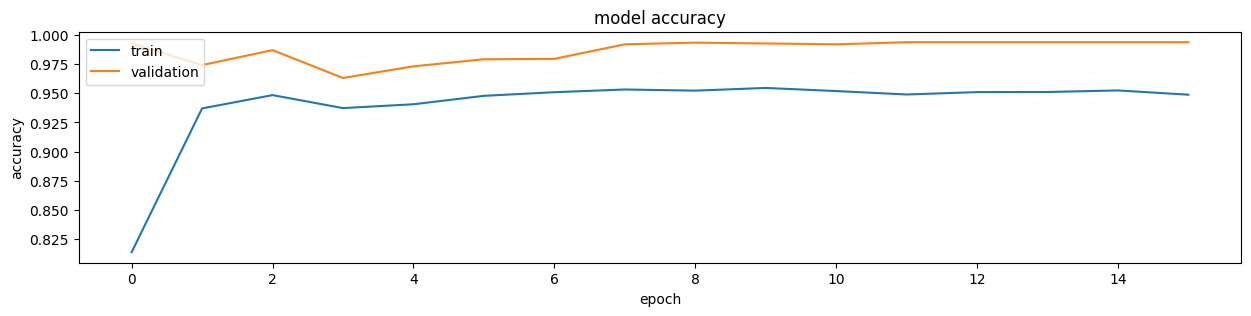

<Figure size 640x480 with 0 Axes>

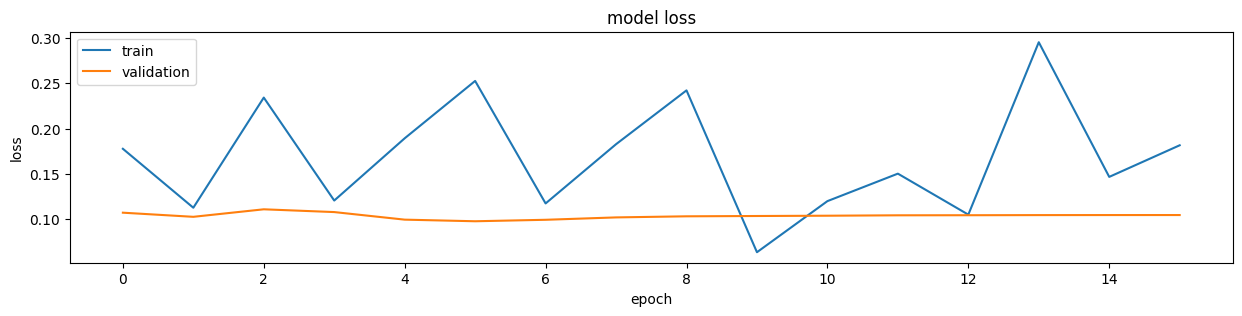

In [40]:
print(history_student.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_student.history['sparse_categorical_accuracy'])
plt.plot(history_student.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_student.history['student_loss'])
plt.plot(history_student.history['val_student_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

57/57 [==============================] - 0s 1ms/step


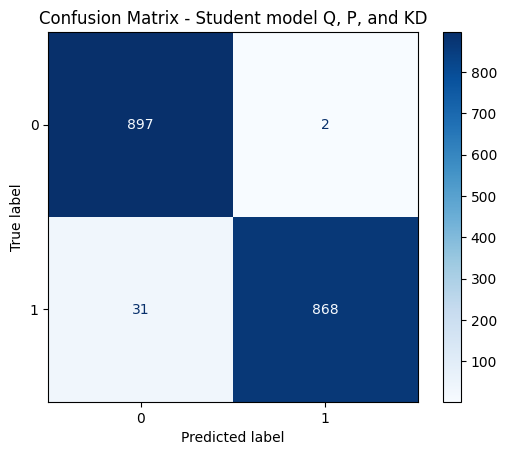

In [41]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = distilled_student.student.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix - Student model Q, P, and KD')
plt.show()

### Prueba de predicción individual

Prueba el modelo con entradas individuales.

La variable indexPrediction corresponde al índice de la señal en el conjunto de datos de prueba. Puedes cambiar este número para observar cómo el modelo basado en ML predice para entradas específicas.

1/1 [==============================] - 0s 16ms/step
> Input [1. 0.] -> Predicted = [[0.7257671  0.08108211]] | 


Text(0.5, 1.0, 'Signal used for inference - Pulse: 1500, Label: [1. 0.], Prediction: [[0.7257671  0.08108211]]')

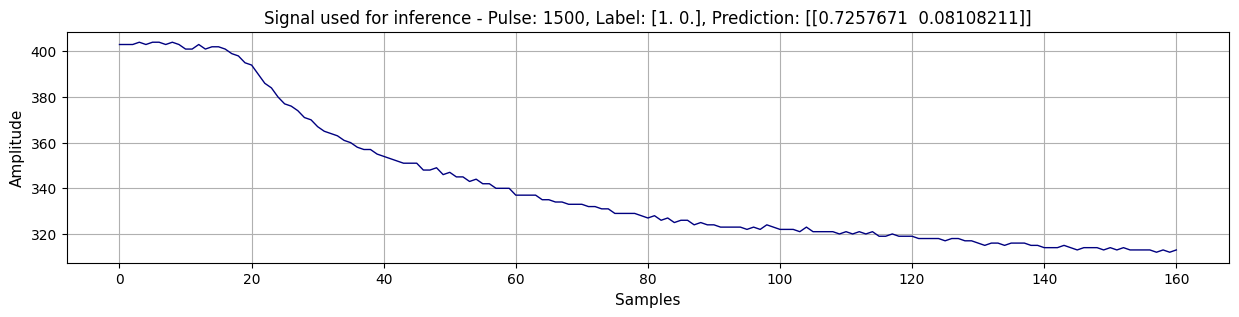

In [42]:
# Index of the signal in the testing dataset
indexPrediction = 1500

x_input = dfTest.iloc[indexPrediction]
y_label = yTest[indexPrediction]

inputPred = array([x_input])

y_pred = distilled_student.student.predict(inputPred) 
print("> Input %s -> Predicted = %s | " % (y_label, y_pred))

plt.figure(figsize=(15,3))
plt.xlabel('Samples', fontsize=11)
plt.ylabel('Amplitude', fontsize=11)
plt.grid(True, alpha=1.0)
plt.plot(x_input.values,  label="Signal 1", color='navy', markersize=7, lw=1)

plt.title('Signal used for inference - Pulse: %s, Label: %s, Prediction: %s' % (indexPrediction, y_label, y_pred))

### Guardar el modelo Student

In [ ]:
model_student = strip_pruning(distilled_student.student)
model_student.summary()

# model_student.save('models/studentModel_GN_GICM.h5')

Model: "studentMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 6)                 972       
                                                                 
 relu0 (QActivation)         (None, 6)                 0         
                                                                 
 dropout_8 (Dropout)         (None, 6)                 0         
                                                                 
 fc2 (QDense)                (None, 4)                 28        
                                                                 
 relu1 (QActivation)         (None, 4)                 0         
                                                                 
 dropout_9 (Dropout)         (None, 4)                 0         
                                                                 
 fc3 (QDense)                (None, 2)                 1

## Analisis comparativo



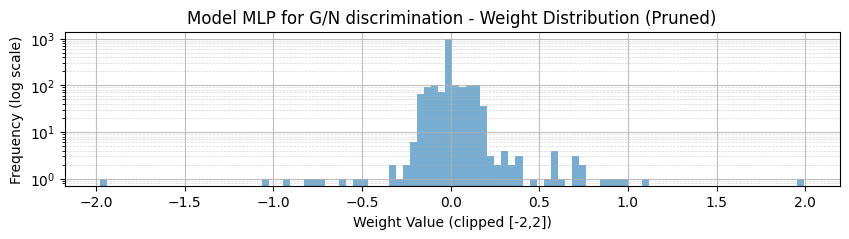

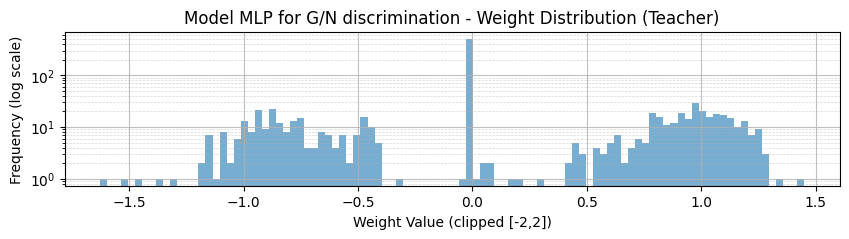

In [44]:
# Weight distribution

weights_stu = np.concatenate([w.flatten() for w in model_student.get_weights()])

# Filtrar pesos entre -2 y 2
weights_stu_clip  = weights_stu[(weights_stu >= -2) & (weights_stu <= 2)]

# Histograma del modelo podado
plt.figure(figsize=(10,2))
plt.hist(weights_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Pruned)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

# Histograma del modelo original
plt.figure(figsize=(10,2))
plt.hist(weights_stu_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Teacher)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

---
**Autor**: Fabian Castaño